In [8]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [1]:
!pip install tensorflow-gpu==2.4.1 

ERROR: Could not find a version that satisfies the requirement tensorflow-gpu==2.4.1 (from versions: 2.5.0, 2.5.1, 2.5.2, 2.5.3, 2.6.0, 2.6.1, 2.6.2, 2.6.3, 2.6.4, 2.6.5, 2.7.0rc0, 2.7.0rc1, 2.7.0, 2.7.1, 2.7.2, 2.7.3, 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1)
ERROR: No matching distribution found for tensorflow-gpu==2.4.1


In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [31]:
!pip install tensorflow-gpu==2.7.0 --user

In [32]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [8]:
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [9]:
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'data\\positive'

In [6]:
!tar -xf lfw.tgz

In [7]:
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

In [8]:
import uuid

In [20]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    
    frame = frame [120:120+250, 200:200+250, :] 
    
    if cv2.waitKey(1) & 0XFF == ord('a'):
        
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        
        cv2.imwrite(imgname, frame)
    
   
    if cv2.waitKey(1) & 0XFF == ord('p'):
        
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        
        cv2.imwrite(imgname, frame)
        
    cv2.imshow('Image Collection', frame)
    
   
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break    
        
cap.release()
cv2.destroyAllWindows()
     

In [9]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(300)

In [10]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0
    
    # Return image
    return img

In [10]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [13]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [16]:
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [17]:
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [18]:
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [16]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [17]:
embedding = make_embedding()
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

In [4]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [19]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')
siamese_model = make_siamese_model()
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [20]:
binary_cross_loss = tf.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

In [21]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [22]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    
    # Return loss
    return loss

In [23]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            train_step(batch)
            progbar.update(idx+1)
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

In [33]:
EPOCHS = 50
train(train_data, EPOCHS)


 Epoch 1/50
27/27 [==============================] - 899s 33s/step

 Epoch 2/50
27/27 [==============================] - 55860s 2147s/step

 Epoch 3/50
27/27 [==============================] - 871s 32s/step

 Epoch 4/50
27/27 [==============================] - 872s 32s/step

 Epoch 5/50
27/27 [==============================] - 871s 32s/step

 Epoch 6/50
27/27 [==============================] - 870s 32s/step

 Epoch 7/50
27/27 [==============================] - 869s 32s/step

 Epoch 8/50
27/27 [==============================] - 892s 33s/step

 Epoch 9/50
27/27 [==============================] - 934s 35s/step

 Epoch 10/50
27/27 [==============================] - 906s 34s/step

 Epoch 11/50
27/27 [==============================] - 906s 34s/step

 Epoch 12/50
27/27 [==============================] - 895s 33s/step

 Epoch 13/50
27/27 [==============================] - 897s 33s/step

 Epoch 14/50
27/27 [==============================] - 901s 33s/step

 Epoch 15/50
27/27 [==================

In [19]:
from tensorflow.keras.metrics import Precision, Recall

In [20]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [25]:
from keras.models import load_model
import h5py
model = tf.keras.models.load_model('siamesemodel.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})
yhat = model.predict([test_input, test_val])
yhat

array([[1.3685591e-12],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0874234e-07],
       [6.1754123e-15],
       [1.2026195e-14],
       [4.2491268e-13],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.2352503e-14],
       [1.4325254e-13],
       [3.9839803e-13],
       [5.9123354e-14],
       [5.3238145e-05],
       [2.9251335e-10]], dtype=float32)

In [27]:
[1 if prediction > 0.5 else 0 for prediction in yhat ]

[0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0]

In [29]:
m = Recall()
m.update_state(y_true, yhat)
m.result().numpy()

1.0

In [30]:
m = Precision()
m.update_state(y_true, yhat)
m.result().numpy()

1.0

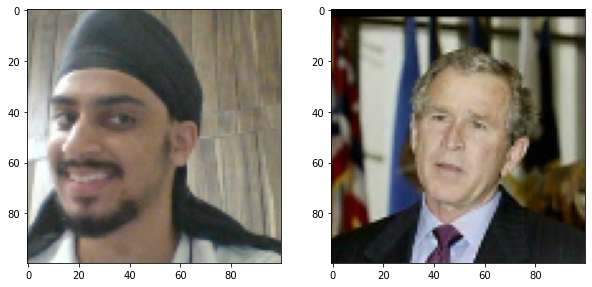

In [32]:
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
plt.imshow(test_input[0])
plt.subplot(1,2,2)
plt.imshow(test_val[0])
plt.show()

In [43]:
siamese_model.save('siamesemodel.h5')

In [44]:
siamese_model.save('siamesemodel.h5')

In [5]:
model = tf.keras.models.load_model('siamesemodel.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [36]:
pre = model.predict([test_input, test_val])

In [37]:
[1 if prediction > 0.5 else 0 for prediction in pre ]

[0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0]

In [15]:
model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [6]:
def verify(model, detection_threshold, verification_threshold):
    
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    
    detection = np.sum(np.array(results) > detection_threshold)
    
    
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

In [13]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(model, 0.4, 0.4)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

False
False


In [10]:
results

[array([[1.4858495e-11]], dtype=float32),
 array([[1.1112352e-12]], dtype=float32),
 array([[4.9596997e-11]], dtype=float32),
 array([[1.0884875e-06]], dtype=float32),
 array([[1.0884875e-06]], dtype=float32),
 array([[1.081023e-07]], dtype=float32),
 array([[1.3539774e-07]], dtype=float32),
 array([[4.7664506e-07]], dtype=float32),
 array([[5.9422257e-07]], dtype=float32),
 array([[3.7047204e-07]], dtype=float32),
 array([[9.37697e-07]], dtype=float32),
 array([[5.623862e-07]], dtype=float32),
 array([[2.6591883e-07]], dtype=float32),
 array([[2.4743446e-07]], dtype=float32),
 array([[1.7715432e-07]], dtype=float32),
 array([[1.7715432e-07]], dtype=float32),
 array([[2.6308635e-07]], dtype=float32),
 array([[5.1915237e-07]], dtype=float32),
 array([[5.060605e-07]], dtype=float32),
 array([[5.885758e-07]], dtype=float32),
 array([[1.0855609e-06]], dtype=float32),
 array([[4.6497524e-07]], dtype=float32),
 array([[7.4909167e-07]], dtype=float32),
 array([[5.6849416e-07]], dtype=float32)